In [1]:
import glob
import re
import mne
import itertools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
N_CHANS = 62

## Average coordinates from captrak files

In [3]:
# Get coordinates of all channels 
epoch_paths = glob.glob('../data/bids/derivatives/preprocessing/*/*res-hi*fif.gz')
pattern = re.compile('sub-(\d{1,2})_')
epoch_sub_order = list(map(pattern.findall, epoch_paths))
epoch_sub_order = list(itertools.chain(*epoch_sub_order))

captrak_paths = glob.glob('../data/captrak/*.bvct')

poss = np.empty([])
# for each captrak file
for i, captrak_path in enumerate(captrak_paths):
    print(f"Reading captrak file: {captrak_path}")

    # get subject
    pattern = re.compile('subj-(\d{1,2})')
    sub = pattern.findall(captrak_path)[0]
    
    # get captrak file
    dig = mne.channels.read_dig_captrak(fname = captrak_path)
    
    # load epochs object for same subject
    ind = epoch_sub_order.index(sub)
    epoch_fpath = epoch_paths[ind]
    print(f"Reading info from epoch file: {epoch_fpath}")
    info = mne.io.read_info(epoch_fpath)

    # get coordinates
    ch_names = info.ch_names
    if len(ch_names) != N_CHANS:
        print(f"ValueError: Incorrect number of channels, skipping subject {sub}!")
        continue
    try:
        pos = np.stack([dig.get_positions()['ch_pos'][ch] for ch in ch_names])
    except:
        print(f"KeyError: {captrak_path} is incomplete, likely missing FCz, skipping subject {sub}!")
        continue
        
    # Add to list
    pos = pos[..., np.newaxis]
    if i == 0:
        poss = pos
    else:
        poss = np.append(poss, pos, axis = 2)
    print(np.shape(poss))

Reading captrak file: ../data/captrak/subj-43.bvct
Reading info from epoch file: ../data/bids/derivatives/preprocessing/sub-43/sub-43_task-pitch_run-1_res-hi_desc-clean_epo.fif.gz
(62, 3, 1)
Reading captrak file: ../data/captrak/subj-9.bvct
Reading info from epoch file: ../data/bids/derivatives/preprocessing/sub-9/sub-9_task-pitch_run-1_res-hi_desc-clean_epo.fif.gz
(62, 3, 2)
Reading captrak file: ../data/captrak/subj-6.bvct
Reading info from epoch file: ../data/bids/derivatives/preprocessing/sub-6/sub-6_task-pitch_run-1_res-hi_desc-clean_epo.fif.gz
(62, 3, 3)
Reading captrak file: ../data/captrak/subj-2.bvct


ValueError: '2' is not in list

In [ ]:
# Calculate mean coordinates
mean_pos = np.mean(poss, axis = 2)
x = mean_pos[:, 0]
y = mean_pos[:, 1]
z = mean_pos[:, 2]

## Get coordinates the dumb way

In [4]:
coords = pd.read_csv('../data/captrak/2dcoords.csv')

## Map coherence values for each channel

In [5]:
# Read coherence files and append all to data frame
path = "../data/bids/derivatives/coherence/*_coh*"
coh = pd.DataFrame()
for fpath in glob.glob(path):
    data = pd.read_pickle(fpath)
    coh = pd.concat([coh, data])
coh = coh.set_index('index')
coh["cond"] = pd.to_numeric(coh["cond"])

In [6]:
# Average over subjects
coh_sub_avg = coh.groupby(['cond', 'chan']).mean()

# Clean up
coh_sub_avg = coh_sub_avg.reset_index()

In [7]:
# Broadcast coordinates
x = np.hstack([coords['x']]*5)
y = np.hstack([coords['y']]*5)

# Add coordinates to data frame
coh_sub_avg['x'], coh_sub_avg['y'] = [x, y]

In [8]:
# Subset coherence values by condition
coh_50 = coh_sub_avg[coh_sub_avg['cond'] == 50]
coh_100 = coh_sub_avg[coh_sub_avg['cond'] == 100]
coh_150 = coh_sub_avg[coh_sub_avg['cond'] == 150]
coh_200 = coh_sub_avg[coh_sub_avg['cond'] == 200]
coh_250 = coh_sub_avg[coh_sub_avg['cond'] == 250]

In [9]:
# Simplify dfs
coh_50 = coh_50[['cond', 'chan', 'x', 'y', '50']]
coh_100 = coh_100[['cond', 'chan', 'x', 'y', '100']]
coh_150 = coh_150[['cond', 'chan', 'x', 'y', '150']]
coh_200 = coh_200[['cond', 'chan', 'x', 'y', '200']]
coh_250 = coh_250[['cond', 'chan', 'x', 'y', '250']]

#### Compute baseline for each channel

In [10]:
# Compute baseline for each channel
control_50 = coh[coh['cond'] != 50]
control_100 = coh[coh['cond'] != 100]
control_150 = coh[coh['cond'] != 150]
control_200 = coh[coh['cond'] != 200]
control_250 = coh[coh['cond'] != 250]

# Baseline for each channel
baseline_50 = control_50.groupby(['chan']).mean()['50']
baseline_100 = control_100.groupby(['chan']).mean()['100']
baseline_150 = control_150.groupby(['chan']).mean()['150']
baseline_200 = control_200.groupby(['chan']).mean()['200']
baseline_250 = control_250.groupby(['chan']).mean()['250']

# Fix indexes
baseline_50 = baseline_50.reset_index(drop = True)
baseline_100 = baseline_100.reset_index(drop = True)
baseline_150 = baseline_150.reset_index(drop = True)
baseline_200 = baseline_200.reset_index(drop = True)
baseline_250 = baseline_250.reset_index(drop = True)

In [11]:
# Create copies
coh_50_baselined = coh_50.copy()
coh_100_baselined = coh_100.copy()
coh_150_baselined = coh_150.copy()
coh_200_baselined = coh_200.copy()
coh_250_baselined = coh_250.copy()

# Subtract baseline
coh_50_baselined['50'] = (coh_50['50'].to_numpy() - baseline_50).tolist()
coh_100_baselined['100'] = (coh_100['100'].to_numpy() - baseline_100).tolist()
coh_150_baselined['150'] = (coh_150['150'].to_numpy() - baseline_150).tolist()
coh_200_baselined['200'] = (coh_200['200'].to_numpy() - baseline_200).tolist()
coh_250_baselined['250'] = (coh_250['250'].to_numpy() - baseline_250).tolist()

#### Plot

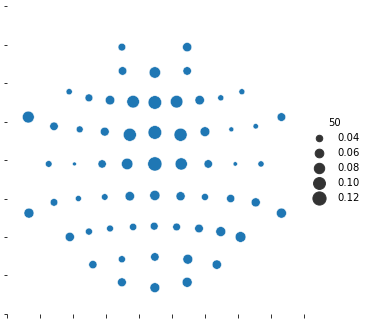

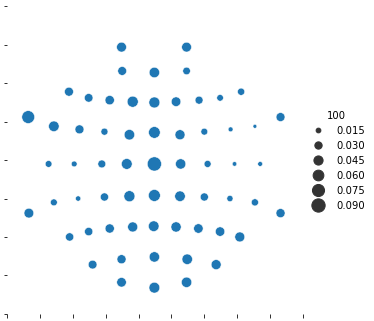

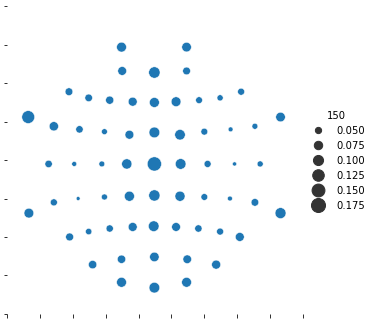

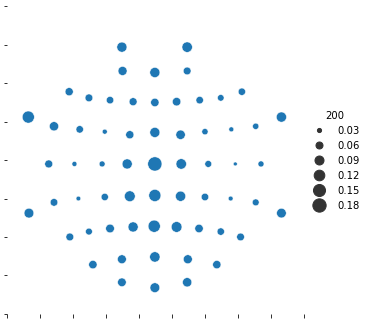

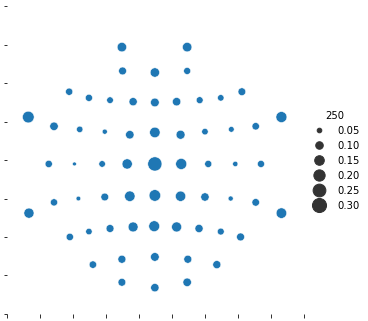

In [12]:
# Plot
ax = sns.relplot(x = "x", y = "y", size = "50", sizes=(15, 200), data = coh_50_baselined)
ax.despine(left = True, bottom = True)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xlabels('')
ax.set_ylabels('')

ax = sns.relplot(x = "x", y = "y", size = "100", sizes=(15, 200), data = coh_100_baselined)
ax.despine(left = True, bottom = True)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xlabels('')
ax.set_ylabels('')

ax = sns.relplot(x = "x", y = "y", size = "150", sizes=(15, 200), data = coh_150_baselined)
ax.despine(left = True, bottom = True)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xlabels('')
ax.set_ylabels('')

ax = sns.relplot(x = "x", y = "y", size = "200", sizes=(15, 200), data = coh_200_baselined)
ax.despine(left = True, bottom = True)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xlabels('')
ax.set_ylabels('')

ax = sns.relplot(x = "x", y = "y", size = "250", sizes=(15, 200), data = coh_250_baselined)
ax.despine(left = True, bottom = True)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xlabels('')
ax.set_ylabels('')

## Map imaginary coherence values for each channel

In [13]:
# Read imcoherence files and append all to data frame
path = "../data/bids/derivatives/coherence/*_imcoh*"
imcoh = pd.DataFrame()
for fpath in glob.glob(path):
    data = pd.read_pickle(fpath)
    imcoh = pd.concat([imcoh, data])
imcoh = imcoh.set_index('index')
imcoh["cond"] = pd.to_numeric(imcoh["cond"])

In [14]:
# Average over subjects
imcoh_sub_avg = imcoh.groupby(['cond', 'chan']).mean()

# Clean up
imcoh_sub_avg = imcoh_sub_avg.reset_index()

In [15]:
# Broadcast coordinates
x = np.hstack([coords['x']]*5)
y = np.hstack([coords['y']]*5)

# Add coordinates to data frame
imcoh_sub_avg['x'], imcoh_sub_avg['y'] = [x, y]

In [16]:
# Subset imcoherence values by condition
imcoh_50 = imcoh_sub_avg[imcoh_sub_avg['cond'] == 50]
imcoh_100 = imcoh_sub_avg[imcoh_sub_avg['cond'] == 100]
imcoh_150 = imcoh_sub_avg[imcoh_sub_avg['cond'] == 150]
imcoh_200 = imcoh_sub_avg[imcoh_sub_avg['cond'] == 200]
imcoh_250 = imcoh_sub_avg[imcoh_sub_avg['cond'] == 250]

In [17]:
# Simplify dfs
imcoh_50 = imcoh_50[['cond', 'chan', 'x', 'y', '50']]
imcoh_100 = imcoh_100[['cond', 'chan', 'x', 'y', '100']]
imcoh_150 = imcoh_150[['cond', 'chan', 'x', 'y', '150']]
imcoh_200 = imcoh_200[['cond', 'chan', 'x', 'y', '200']]
imcoh_250 = imcoh_250[['cond', 'chan', 'x', 'y', '250']]

In [18]:
# Compute absolute value of imcoh
imcoh_50['50'] = abs(imcoh_50['50'])
imcoh_100['100'] = abs(imcoh_100['100'])
imcoh_150['150'] = abs(imcoh_150['150'])
imcoh_200['200'] = abs(imcoh_200['200'])
imcoh_250['250'] = abs(imcoh_250['250'])

#### Baselining

In [19]:
# Compute baseline for each channel
control_50 = imcoh[imcoh['cond'] != 50]
control_100 = imcoh[imcoh['cond'] != 100]
control_150 = imcoh[imcoh['cond'] != 150]
control_200 = imcoh[imcoh['cond'] != 200]
control_250 = imcoh[imcoh['cond'] != 250]

# Baseline for each channel
baseline_50 = control_50.groupby(['chan']).mean()['50']
baseline_100 = control_100.groupby(['chan']).mean()['100']
baseline_150 = control_150.groupby(['chan']).mean()['150']
baseline_200 = control_200.groupby(['chan']).mean()['200']
baseline_250 = control_250.groupby(['chan']).mean()['250']

# Fix indexes
baseline_50 = baseline_50.reset_index(drop = True)
baseline_100 = baseline_100.reset_index(drop = True)
baseline_150 = baseline_150.reset_index(drop = True)
baseline_200 = baseline_200.reset_index(drop = True)
baseline_250 = baseline_250.reset_index(drop = True)

In [20]:
# Create copies
imcoh_50_baselined = imcoh_50.copy()
imcoh_100_baselined = imcoh_100.copy()
imcoh_150_baselined = imcoh_150.copy()
imcoh_200_baselined = imcoh_200.copy()
imcoh_250_baselined = imcoh_250.copy()

# Subtract baseline
imcoh_50_baselined['50'] = (imcoh_50['50'].to_numpy() - baseline_50).tolist()
imcoh_100_baselined['100'] = (imcoh_100['100'].to_numpy() - baseline_100).tolist()
imcoh_150_baselined['150'] = (imcoh_150['150'].to_numpy() - baseline_150).tolist()
imcoh_200_baselined['200'] = (imcoh_200['200'].to_numpy() - baseline_200).tolist()
imcoh_250_baselined['250'] = (imcoh_250['250'].to_numpy() - baseline_250).tolist()

#### Plot

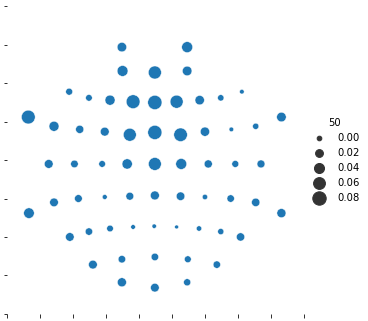

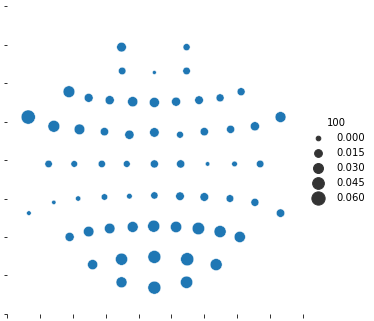

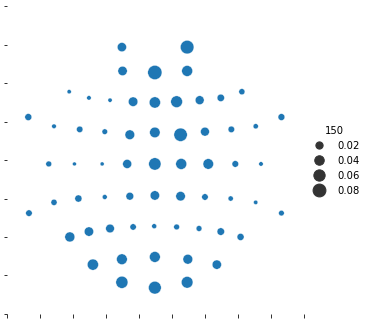

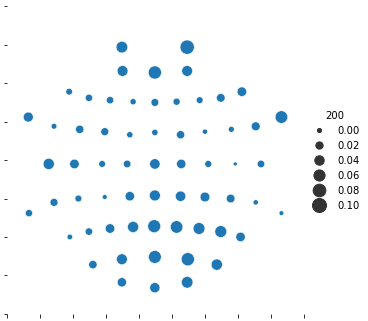

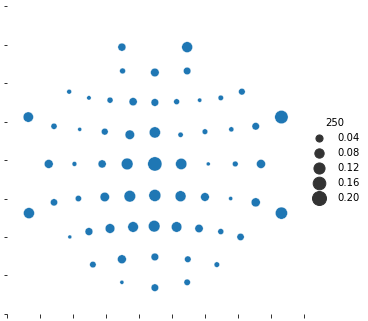

In [21]:
# Plot
ax = sns.relplot(x = "x", y = "y", size = "50", sizes=(15, 200), data = imcoh_50_baselined)
ax.despine(left = True, bottom = True)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xlabels('')
ax.set_ylabels('')

ax = sns.relplot(x = "x", y = "y", size = "100", sizes=(15, 200), data = imcoh_100_baselined)
ax.despine(left = True, bottom = True)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xlabels('')
ax.set_ylabels('')

ax = sns.relplot(x = "x", y = "y", size = "150", sizes=(15, 200), data = imcoh_150_baselined)
ax.despine(left = True, bottom = True)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xlabels('')
ax.set_ylabels('')

ax = sns.relplot(x = "x", y = "y", size = "200", sizes=(15, 200), data = imcoh_200_baselined)
ax.despine(left = True, bottom = True)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xlabels('')
ax.set_ylabels('')

ax = sns.relplot(x = "x", y = "y", size = "250", sizes=(15, 200), data = imcoh_250_baselined)
ax.despine(left = True, bottom = True)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xlabels('')
ax.set_ylabels('')

In [ ]:
# Plot mean coordinates
rng = np.random.RandomState(0)
data = rng.normal(size=(N_CHANS, 1)) * 1e-6
fake_evoked = mne.EvokedArray(data, info)
fake_evoked.set_montage(dig)
fake_evoked.plot_sensors()

In [ ]:
np.shape(np.hstack([z]*5))

In [ ]:
n_channels = 62
n_samples = 1
rng = np.random.RandomState(0)
data = rng.normal(size=(n_channels, 1)) * 1e-6
# info = mne.create_info(62, 5000, ch_types = 'eeg')
fake_evoked = mne.EvokedArray(data, epoch.info)
fake_evoked.set_montage(dig)
fake_evoked.plot_sensors()

In [ ]:
epochs_path = glob.glob('../data/bids/derivatives/preprocessing/*/*res-hi*')
pattern = re.compile('sub-(\d{1,2})_')
epoch_sub_order = list(map(pattern.findall, epochs_path))
epoch_sub_order = list(itertools.chain(*epoch_sub_order))

captrak_path = glob.glob('../data/captrak/*.bvct')
# pattern = re.compile('subj-(\d{1,2})')
# captrak_sub_order = list(map(pattern.findall, captrak_path))
# captrak_sub_order = list(itertools.chain(*captrak_sub_order))

# n_subs = len(captrak_path)
# poss = np.empty([n_subs, N_CHANS, 3])
poss = []
# for each captrak file
for file in captrak_path:
    # get subject
    pattern = re.compile('subj-(\d{1,2})')
    sub = pattern.findall(fpath)[0]
    
    # get corresponding captrak file
    dig = mne.channels.read_dig_captrak(fname = file)
    
    # load their epochs object
    ind = epoch_sub_order.index('43')
    epoch_fpath = epochs_path[ind]
    epochs = mne.read_epochs(epoch_fpath, preload = False)

    # get coordinates
    ch_names = epochs.ch_names
    if len(ch_names) != N_CHANS:
        print(f"Incorrect number of channels, skipping subjet {sub}")
        continue
    pos = np.stack([dig.get_positions()['ch_pos'][ch] for ch in ch_names])
    poss = [poss, pos]
    
# Plot mean coordinates
# rng = np.random.RandomState(0)
# data = rng.normal(size=(N_CHANS, 1)) * 1e-6
# fake_evoked = mne.EvokedArray(data, epoch.info)
# fake_evoked.set_montage(dig)
# fake_evoked.plot_sensors()
    